# Unit Simulation Experimental Notebook

In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
# our simulator
import battlesim as bsm

### Trial 1. 50 Clone Troopers vs. 80 B1 battledroids

Using Random AI selection for targets.

In [2]:
import re

In [3]:
trial1 = bsm.Battle("datasets/starwars-clonewars.csv")
# define 100 battledroids, 50 clones
trial1.create_army([("B1 battledroid", 1000), ("Clone Trooper", 200), ("Clone Trooper", 150)])
# battle droids near (0, 0), clones near (10, 10)
trial1.apply_position([
    dict(name="uniform", x_loc=-5., scale=2.),
    dict(name="gaussian", loc=0.),
    dict(name="gaussian", x_loc=4., y_loc=5.),
])
#init, rolling AIs now default to 'nearest'
trial1.set_decision_ai(["aggressive","hit_and_run","hit_and_run"])
# set boundary
trial1.set_bounds((-10., 10., -10., 20.))
# set terrain
trial1.apply_terrain("contour", res=1.)

/home/gparkes/Documents/BattleSimulator/battlesim/battle.py:313: UserWarning: argument 'f' is currently unused in apply_terrain(*args).
  warnings.warn("argument 'f' is currently unused in apply_terrain(*args).", UserWarning)


bsm.Battle(init=True, n_armies=3, simulated=False)

In [4]:
# run a battle
F = trial1.simulate(max_step=1500)

In [5]:
trial1.composition_

,unit,allegiance,n,position,init_ai,rolling_ai,decision_ai
0,b1 battledroid,CIS,1000,"uniform (-5.0, 0.0)",nearest,nearest,aggressive
1,clone trooper,Republic,200,"norm (0.0, 0.0)",nearest,nearest,hit_and_run
2,clone trooper,Republic,150,"norm (4.0, 5.0)",nearest,nearest,hit_and_run


In [15]:
F.memory_usage()

Index         1555200
army           194400
allegiance     194400
alive          194400
x              777600
y              777600
dir_x          777600
dir_y          777600
dtype: int64

In [9]:
F.memory_usage().sum()/1000000

5.2488

In [10]:
F.shape

(194400, 7)

In [13]:
trial1.sim_jupyter()

## Testing Performance Profiling

In [14]:
%timeit trial1.simulate()

2.52 s ± 78.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### With and without hit-and-run tactics..  Wow

In [14]:
trial1.set_decision_ai(["aggressive","hit_and_run","hit_and_run"])
F = trial1.simulate_k(10,max_step=500)

trial1.set_decision_ai(["aggressive"]*3)
F2 = trial1.simulate_k(10,max_step=500)

C = pd.concat([
    F.melt(var_name="team", value_name="number of units").assign(Run="w/ hit and run"),
    F2.melt(var_name="team", value_name="number of units").assign(Run="w/o hit and run"),
], axis=0)

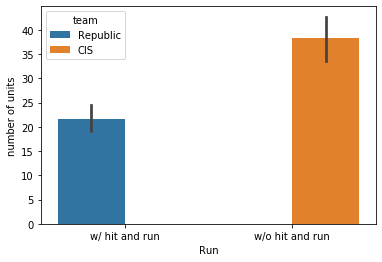

In [15]:
import seaborn as sns
sns.barplot(data=C, x="Run", y="number of units", hue="team")
plt.show()

In [16]:
%prun trial1.simulate()

In [ ]:
%prun trial1.simulate_k(1)